In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Preprocessing

In [2]:
train_data = pd.read_csv('sample_data/mnist_train_small.csv', encoding='utf-8')
test_data = pd.read_csv('sample_data/mnist_test.csv', encoding='utf=8')
print(train_data.head(5))
print(test_data.head(5))

   6  0  0.1  0.2  0.3  0.4  ...  0.585  0.586  0.587  0.588  0.589  0.590
0  5  0    0    0    0    0  ...      0      0      0      0      0      0
1  7  0    0    0    0    0  ...      0      0      0      0      0      0
2  9  0    0    0    0    0  ...      0      0      0      0      0      0
3  5  0    0    0    0    0  ...      0      0      0      0      0      0
4  2  0    0    0    0    0  ...      0      0      0      0      0      0

[5 rows x 785 columns]
   7  0  0.1  0.2  0.3  0.4  ...  0.662  0.663  0.664  0.665  0.666  0.667
0  2  0    0    0    0    0  ...      0      0      0      0      0      0
1  1  0    0    0    0    0  ...      0      0      0      0      0      0
2  0  0    0    0    0    0  ...      0      0      0      0      0      0
3  4  0    0    0    0    0  ...      0      0      0      0      0      0
4  1  0    0    0    0    0  ...      0      0      0      0      0      0

[5 rows x 785 columns]


In [3]:
train_labels = np.array(train_data['6'])
train_images = np.array(train_data.drop('6', axis = 1)).T
test_labels = np.array(test_data['7'])
test_images = np.array(test_data.drop('7', axis = 1)).T

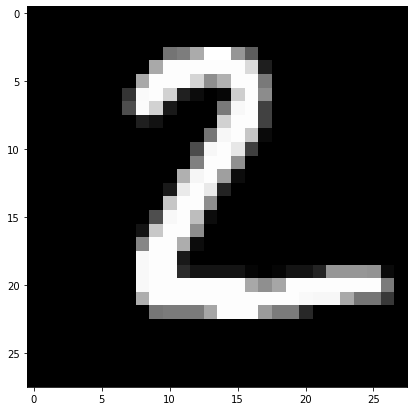

Number shown:  2


In [4]:
plt.figure(figsize = (7,7))
idx = 0

grid_data = test_images[:,idx].reshape(28,28)
plt.imshow(grid_data, cmap = "gray")
plt.show()

print("Number shown: ", test_labels[idx])

In [5]:
m = train_labels.shape[0]
m_test = test_labels.shape[0]
print("Training examples 'm': ",m)
print("Test examples 'm_test': ",m_test)
X = train_images/255
X_test = test_images/255
print("X.shape = ",X.shape)
print("X_test.shape = ", X_test.shape)
print(train_labels.shape)

Training examples 'm':  19999
Test examples 'm_test':  9999
X.shape =  (784, 19999)
X_test.shape =  (784, 9999)
(19999,)


In [6]:
#print(train_labels.max())
#print(train_labels)
nums_train = np.unique(train_labels)
nums_test = np.unique(test_labels)
print("Numbers in train images = ", nums_train)
print("Numbers in test images = ", nums_test)
flag = np.array_equal(nums_train, nums_test)
print("Numbers in test and train are common?: ", flag)
assert (flag), 'train_labels != test_labels_'
numbers = nums_train

Numbers in train images =  [0 1 2 3 4 5 6 7 8 9]
Numbers in test images =  [0 1 2 3 4 5 6 7 8 9]
Numbers in test and train are common?:  True


In [7]:
nClass = len(numbers)
print("No. of classes: ", nClass)

No. of classes:  10


In [8]:
def one_hot(nClass, labels):
    one_hot_labels = np.eye(nClass)[np.array(labels)].T
    return one_hot_labels

In [9]:
one_hot(10, [1,3,7]) # check if one-hot function gives desired output

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [10]:
Y_hot = one_hot(nClass, train_labels)
Y_test_hot = one_hot(nClass, test_labels)
print('Y_hot.shape = ', Y_hot.shape)
print('Y_test_hot.shape = ', Y_test_hot.shape)

Y_hot.shape =  (10, 19999)
Y_test_hot.shape =  (10, 9999)


Hyperparameters


In [11]:
nn_size = np.array([X.shape[0], 512, 128, 32, 10])


Neural Network

In [12]:
class Classifier():
    def __init__(self, nn_size, lr):
        self.learning_rate = lr
        self.nLayers = len(nn_size)
        self.nn_size = nn_size
    
    def init_weights(self):
        W = {}
        b = {}
        for i in range(1,self.nLayers):
            W[f'{i-1}->{i}'] = np.random.randn(self.nn_size[i],self.nn_size[i-1])*np.sqrt(2/self.nn_size[i-1])
            b[f'{i-1}->{i}'] = np.zeros((self.nn_size[i],1))
        
        self.W = W
        self.b = b       

    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_prime(self, da, z):
        dz = np.array(da, copy=True)
        dz[z<=0] = 0
        dz[z>0] = 1
        return dz

        
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=0)
    
    def forward(self, X):
        A = {}
        Z = {}
        
        A[f'{0}'] = X # first layer is simply the input

        # FEEDFORWARD (until second-last layer)
        # A[i] = activation( Z[i] ) where Z[i] = W[i-1 -> i] A[i-1] + b
        for i in range(1, self.nLayers - 1):
            Z[f'{i}'] = np.dot(self.W[f'{i-1}->{i}'], A[f'{i-1}']) + self.b[f'{i-1}->{i}']
            A[f'{i}'] = self.relu(Z[f'{i}'])

        # FEEDFORWARD (last layer using softmax)
        i = self.nLayers - 1
        Z[f'{i}'] = np.dot(self.W[f'{i-1}->{i}'], A[f'{i-1}']) + self.b[f'{i-1}->{i}']
        A[f'{i}'] = self.softmax(Z[f'{i}'])  # [nClass, 1]

        #print('Shapes of Z and A')
        #for key in list(Z.keys()):
        #    print(Z[key].shape)
        #    #print(A[key].shape)

        return A, Z 
    
    def cost(self, pred, targ):
        m = pred.shape[1]
        L = -np.sum(targ * np.log(pred), axis=0) # Total Cross entropy loss
        J = (1/m) * np.sum(L)
        return J

    def backward(self, A, Z, Y):
        """
        To calculate ∂J/∂W, ∂J/∂b for each layer
        
        We know, 
        ∂J/∂Z{l} = SoftmaxLayer (S) - TargetY (Y)                 .... (1)
        And,
        ∂Z_{l}/∂A_{l-1} = W_{l}                                   .... (2)
        ∂A_{l-1}/∂Z_{l-1} = σ'(Z_{l-1})                           .... (3)
        
        For last layer {l},
        ∂J/∂W_{l} = ∂J/∂Z_{l} × ∂Z_{l}/∂W_{l}
        ie.
        ∂J/∂W_{l} = (S - Y)  × A_{l-1}                            .... (4)
        Similarly, ∂J/db_{l} = (S - Y) × [[1,1,1,.....,1]]        .... (5)

        For second last layer hindwards {l-1},
        ∂J/dW_{l-1} = ∂J/∂Z_{l-1} × ∂Z_{l-1}/∂W_{l-1}
        ie.
        ∂J/dW_{l-1} = ∂J/∂Z_{l-1} × A_{l-2}                         .... (6)
        Similary, ∂J/db_{l-1} = ∂J/∂Z_{l-1} × [[1,1,1,.....,1]]     .... (7)
        The above two values can be found by plugging in equations (1), (2) and (3) wherever required


        We will use equations (4) & (5) for last layer and equations (6) & (7) for other layers         
        """
        dJdZ = {}
        dJdW = {}
        dJdb = {}
        dJdA = {}

        l = self.nLayers - 1 
        m = np.shape(A[f'{0}'])[0]
        S = A[f'{l}']
        dJdZ[f'{l}'] = S - Y                                                                  # (1)
        dJdW[f'{l}'] = np.dot(dJdZ[f'{l}'], A[f'{l-1}'].T) /m                                 # (4)
        dJdb[f'{l}'] = np.sum(dJdZ[f'{l}'], axis=1, keepdims=True) / m                        # (5)
        dJdA[f'{l-1}'] = np.dot(self.W[f'{l-1}->{l}'].T, dJdZ[f'{l}']) 

        for i in range(l-1,0,-1):
            dJdZ[f'{i}'] = np.multiply(dJdA[f'{i}'], self.relu_prime(dJdA[f'{i}'],Z[f'{i}']))
            dJdW[f'{i}'] = np.dot(dJdZ[f'{i}'], A[f'{i-1}'].T) / m                            # (6)
            dJdb[f'{i}'] = np.sum(dJdZ[f'{i}'],axis=1, keepdims=True) / m                     # (7)
            dJdA[f'{i-1}'] = np.dot(self.W[f'{i-1}->{i}'].T, dJdZ[f'{i}'])
        
        #print('Shapes of dW and db')
        #for key in list(dJdW.keys()):
        #    print(dJdW[key].shape)
        #    print(dJdb[key].shape)

        return dJdW, dJdb

    def optimize(self, dJdW, dJdb):
          LR = self.learning_rate
          for i in range(1, self.nLayers):
              self.W[f'{i-1}->{1}'] = self.W[f'{i-1}->{i}'] - LR * dJdW[f'{i}']
              self.b[f'{i-1}->{i}'] = self.b[f'{i-1}->{i}'] - LR * dJdb[f'{i}']

In [31]:
model = Classifier(nn_size = nn_size, lr=0.005)
model.init_weights()
# Shapes of W and b
#print('W/b')
#for key in list(model.W.keys()):
#    print(model.W[key].shape)
#    print(model.b[key].shape)
nEpoch = 20

# TRAINING
losses = []
for i in range(nEpoch):
    A, Z = model.forward(X)
    loss = model.cost(A[f'{len(nn_size)-1}'], Y_hot)
    print(loss)
    losses.append(loss)
    dJdW, dJdb = model.backward(A, Z, Y_hot)
    model.optimize(dJdW, dJdb)

2.3833711737079932
2.3004059476845256
2.2340243895970744
2.1759666190422426
2.1244357097958706
2.077737991374188
2.034086823050801
1.992067921925108
1.950788390208797
1.9098187565559699
1.8686089498932679
1.8268551730613771
1.7845736615755061
1.7423483169527787
1.7008624868412936
1.660613371726649
1.6217610228156327
1.584542657706488
1.5489607067115403
1.5150084563016193


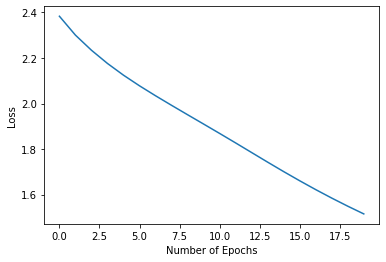

In [33]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.show()